In [1]:
import numpy as np
import pandas as pd

In [6]:
total_data = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/flicker/final_flicker_30k_bb_annot.csv")

In [10]:
total_data.head(2)

,caption,question,image_id,candidate_bb_info
0,Three people are on a sidewalk.,How many people are on the sidewalk?,1191423753,"{'Three': [{'xmin': 351, 'ymin': 177, 'xmax': ..."
1,"Beautiful brunette woman, draped in purple, bl...",What colors are the scarves draped around the ...,1360456780,"{'Beautiful': [{'xmin': 106, 'ymin': 38, 'xmax..."


In [8]:
total_data["image_id"] = total_data["image_id"].apply(lambda x: str(int(x)))

In [23]:
def reformat_bounding_boxes(data):
    new_formatted_values = []
    for key,value in eval(data).items():
        if value == []:
            continue
        formatted_values = {}
        formatted_values['word'] = key
        formatted_values['bbox'] = value
        formatted_values['class'] = None
        new_formatted_values.append(formatted_values)
    return str(new_formatted_values)

In [26]:
total_data["candidate_bb_info"] = total_data["candidate_bb_info"].apply(lambda x: reformat_bounding_boxes(x))

In [27]:
total_data.columns = ["answer", "question", "image_id", "target_words"]

In [29]:
total_data

,answer,question,image_id,target_words
0,Three people are on a sidewalk.,How many people are on the sidewalk?,1191423753,"[{'word': 'Three', 'bbox': [{'xmin': 351, 'ymi..."
1,"Beautiful brunette woman, draped in purple, bl...",What colors are the scarves draped around the ...,1360456780,"[{'word': 'Beautiful', 'bbox': [{'xmin': 106, ..."
2,A woman is welding metal at a work table.,What is the woman doing at the work table?,1897067588,"[{'word': 'woman', 'bbox': [{'xmin': 173, 'ymi..."
3,A girl in a white shirt is holding a ball and ...,What is the girl pointing at?,208472767,"[{'word': 'girl', 'bbox': [{'xmin': 15, 'ymin'..."
4,"The large, dark colored dog is doing a climbin...","What is the large, dark-colored dog doing?",2176364472,"[{'word': 'large', 'bbox': [{'xmin': 185, 'ymi..."
...,...,...,...,...
31630,A black dog in water.,What color is the dog?,3602838407,"[{'word': 'black', 'bbox': [{'xmin': 124, 'ymi..."
31631,A woman with dark hair and wearing a black tan...,What is the woman wearing?,4505867963,"[{'word': 'woman', 'bbox': [{'xmin': 18, 'ymin..."
31632,Two babies are sitting on the floor next to th...,Why is one baby crying?,48614561,"[{'word': 'Two', 'bbox': [{'xmin': 151, 'ymin'..."
31633,A little boys is enjoying a blue lollipop.,What is the boy eating?,6178994097,"[{'word': 'little', 'bbox': [{'xmin': 4, 'ymin..."


In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

def plot_bounding_boxes_xyxy(image_path, boxes):
    """
    Plots bounding boxes on an image using matplotlib.

    Args:
        image_path (str): Path to the image file.
        boxes (list[dict]): List of bounding boxes in dict format.
                            Each box should have keys: {'xmin', 'ymin', 'xmax', 'ymax'}
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Get a set of distinct colors
    colors = list(plt.cm.tab10.colors)
    random.shuffle(colors)

    # Draw each bounding box
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        color = colors[i % len(colors)]
        
        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=2,
                                 edgecolor=color,
                                 facecolor='none')
        ax.add_patch(rect)
        
        # Label each box
        ax.text(xmin, ymin - 5, f"Box {i+1}", color=color,
                fontsize=10, fontweight="bold", backgroundcolor='white')

    plt.axis('off')
    plt.show()

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

def _to_pil(img, image_processor=None):
    """Convert PIL / numpy / processor-normalized tensor -> PIL.Image (uint8)."""
    if isinstance(img, Image.Image):
        return img

    if isinstance(img, torch.Tensor):
        # Accept (B,3,H,W) or (3,H,W). If normalized, unnormalize via processor.
        if img.ndim == 4:
            img = img[0]
        assert img.ndim == 3 and img.shape[0] in (1,3), "Expect (C,H,W) tensor."
        x = img.clone()

        # If in [-~3, ~3] range (typical normalized), try unnormalize
        if image_processor is not None and (x.max() > 1.5 or x.min() < -0.5):
            mean = torch.tensor(
                getattr(image_processor, "image_mean", [0.5, 0.5, 0.5]),
                dtype=x.dtype, device=x.device
            )[:, None, None]
            std = torch.tensor(
                getattr(image_processor, "image_std", [0.5, 0.5, 0.5]),
                dtype=x.dtype, device=x.device
            )[:, None, None]
            x = x * std + mean

        # Move to CPU, [0,1], CHW->HWC uint8
        x = x.clamp(0,1).permute(1,2,0).detach().cpu().numpy()
        arr = (x * 255).round().astype(np.uint8)
        return Image.fromarray(arr)

    if isinstance(img, np.ndarray):
        if img.dtype != np.uint8:
            arr = np.clip(img, 0, 1)
            arr = (arr * 255).round().astype(np.uint8)
        else:
            arr = img
        if arr.ndim == 3 and arr.shape[2] == 3:
            return Image.fromarray(arr)
        raise ValueError("NumPy image must be HxWx3.")
    raise TypeError("Unsupported image type. Use PIL.Image, torch.Tensor, or np.ndarray.")

def _coerce_boxes(boxes):
    norm = []
    for b in boxes:
        if isinstance(b, dict):
            xmin, ymin, xmax, ymax = b["xmin"], b["ymin"], b["xmax"], b["ymax"]
        else:
            xmin, ymin, xmax, ymax = b  # (xmin,ymin,xmax,ymax)
        norm.append((float(xmin), float(ymin), float(xmax), float(ymax)))
    return norm

def plot_boxes_on_image(image_or_tensor, boxes, image_processor=None, labels=None,
                        linewidth=2, color="red"):
    """
    Draw bounding boxes with optional color or per-box color list.
    """
    pil = _to_pil(image_or_tensor, image_processor=image_processor)
    W, H = pil.size
    print(f"Image size: {W}x{H}")
    boxes = _coerce_boxes(boxes)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(pil)
    ax.axis("off")

    # Default color
    if color is None:
        color = "red"

    for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
        xi, yi, xa, ya = map(int, [xmin, ymin, xmax, ymax])
        left, top = min(xi, xa), min(yi, ya)
        w, h = abs(xa - xi), abs(ya - yi)

        # Allow color to be a single string or list of colors per box
        this_color = color[i] if isinstance(color, (list, tuple)) and len(color) == len(boxes) else color

        rect = Rectangle((left, top), w, h,
                         linewidth=linewidth,
                         edgecolor=this_color,
                         facecolor='none')   # <--- no fill, colored edge
        ax.add_patch(rect)

        if labels is not None:
            ax.text(left, max(10, top - 4), str(labels[i]),
                    fontsize=9,
                    color=this_color,
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1.5))

    plt.tight_layout()
    return fig, ax

In [32]:
from typing import List, Dict, Tuple, Optional
from PIL import Image
import math

def map_bboxes_to_llava336(
    image_path: str,
    boxes: List[Dict[str, int]],
    target_shortest: int = 336,
    crop_size: Tuple[int, int] = (336, 336),
    do_center_crop: bool = True,
    drop_empty: bool = True,
) -> Tuple[List[Dict[str, int]], Dict[str, int]]:
    """
    Map (xmin, ymin, xmax, ymax) boxes from original image coords to the
    LLaVA/CLIP-processed 336x336 space.
    
    Args:
        image_path: path to original image.
        boxes: list of dicts like {"xmin": int, "ymin": int, "xmax": int, "ymax": int}
        target_shortest: shortest edge after resize (typically 336 for LLaVA-1.5 @336).
        crop_size: final crop size (h, w). Typically (336, 336).
        do_center_crop: True to mirror CLIP’s center crop; False if your pipeline skipped crop.
        drop_empty: if True, discard boxes that have no overlap after crop. If False, returns
                    clipped zero/negative-area boxes (still clipped to [0, crop_dim]).
    
    Returns:
        (new_boxes, params)
        new_boxes: list of dicts in same structure with integer coords within [0, crop_dim].
        params: dict with scale and offsets used: 
                {"scale": s, "resized_h": Hs, "resized_w": Ws, "offset_x": ox, "offset_y": oy,
                 "out_h": out_h, "out_w": out_w}
    """
    # 1) Read dims
    with Image.open(image_path) as im:
        W, H = im.size  # PIL: (width, height)
    
    # 2) Resize to set shortest edge = target_shortest
    shortest = min(H, W)
    s = target_shortest / float(shortest)
    Hs = int(round(H * s))
    Ws = int(round(W * s))
    
    # 3) Center crop params (if enabled)
    out_h, out_w = crop_size
    if do_center_crop:
        ox = max(0, (Ws - out_w) // 2)  # crop left in resized space
        oy = max(0, (Hs - out_h) // 2)  # crop top  in resized space
    else:
        # No crop → output is just the resized image
        ox = 0
        oy = 0
        out_h, out_w = Hs, Ws
    
    def _transform_one(b):
        # scale with safe rounding (expand slightly after scale)
        xmin_s = math.floor(b["xmin"] * s)
        ymin_s = math.floor(b["ymin"] * s)
        xmax_s = math.ceil(b["xmax"] * s)
        ymax_s = math.ceil(b["ymax"] * s)
        
        # shift by crop offsets
        xmin_c = xmin_s - ox
        ymin_c = ymin_s - oy
        xmax_c = xmax_s - ox
        ymax_c = ymax_s - oy
        
        # clip to output frame
        xmin_c = max(0, min(out_w, xmin_c))
        ymin_c = max(0, min(out_h, ymin_c))
        xmax_c = max(0, min(out_w, xmax_c))
        ymax_c = max(0, min(out_h, ymax_c))
        
        return {"xmin": int(xmin_c), "ymin": int(ymin_c), "xmax": int(xmax_c), "ymax": int(ymax_c)}
    
    mapped = []
    for b in boxes:
        nb = _transform_one(b)
        if drop_empty:
            if nb["xmax"] > nb["xmin"] and nb["ymax"] > nb["ymin"]:
                mapped.append(nb)
        else:
            mapped.append(nb)
    
    params = {
        "scale": s,
        "resized_h": Hs,
        "resized_w": Ws,
        "offset_x": ox,
        "offset_y": oy,
        "out_h": out_h,
        "out_w": out_w,
    }
    return mapped, params

In [33]:
def apply_downscale_bb(image_path, bb_info):
    bb_info = eval(bb_info)
    ds_bb_info = []
    for i in bb_info:
        new_boxes, _ = map_bboxes_to_llava336(
            image_path=image_path,
            boxes = i["bbox"],
            target_shortest=336,
            crop_size=(336, 336),
            do_center_crop=True,
            drop_empty=False
        )
        i["bbox"] = new_boxes
        ds_bb_info.append(i)
    return ds_bb_info

In [41]:
from tqdm import tqdm
all_ds_bb_info = []
for inx, row in tqdm(total_data.iterrows()):
    image_path = "/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/flicker/flickr30k-images/" + row["image_id"] + ".jpg"
    ds_bb_info = apply_downscale_bb(image_path, row["target_words"])
    all_ds_bb_info.append(ds_bb_info)

31635it [00:22, 1421.18it/s]


In [42]:
total_data["downscale_target_words_bb_info"] = all_ds_bb_info

In [43]:
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
image_processor = CLIPImageProcessor.from_pretrained('openai/clip-vit-large-patch14-336')

/home/user/.conda/envs/shdm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/user/.conda/envs/shdm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [64]:
i = 12112
image_path =  "/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/flicker/flickr30k-images/" + total_data["image_id"].iloc[i] + ".jpg"
print(len(total_data["target_words"].iloc[i]))
print(len(total_data["downscale_target_words_bb_info"].iloc[i]))
print(total_data["question"].iloc[i])
print(total_data["answer"].iloc[i])

610
4
What kind of event are the two female tennis players participating in?
Two female tennis players showing great sportsmanship at a tennis match.


In [66]:
j = 1
eval(total_data["target_words"].iloc[i])[j]

{'word': 'female',
 'bbox': [{'xmin': 109, 'ymin': 154, 'xmax': 251, 'ymax': 500},
  {'xmin': 210, 'ymin': 174, 'xmax': 338, 'ymax': 500}],
 'class': None}

In [67]:
j = 2
total_data["downscale_target_words_bb_info"].iloc[i][j]

{'word': 'tennis',
 'bbox': [{'xmin': 73, 'ymin': 103, 'xmax': 169, 'ymax': 336},
  {'xmin': 141, 'ymin': 116, 'xmax': 228, 'ymax': 336}],
 'class': None}

In [68]:
from PIL import Image

image = Image.open(image_path).convert("RGB")
image_tensor = image_processor([image], return_tensors="pt")["pixel_values"]

Image size: 336x336


(<Figure size 600x600 with 1 Axes>, <Axes: >)

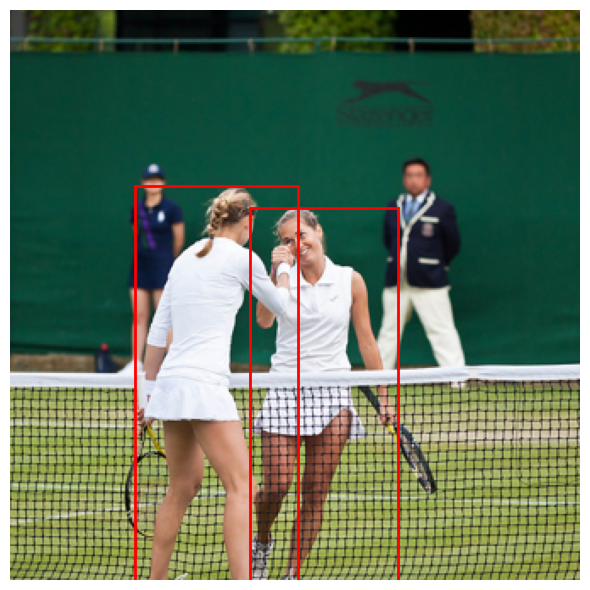

In [69]:
plot_boxes_on_image(image_tensor, total_data["downscale_target_words_bb_info"].iloc[i][j]["bbox"], image_processor=image_processor, labels=None,
                        linewidth=2, color="red")

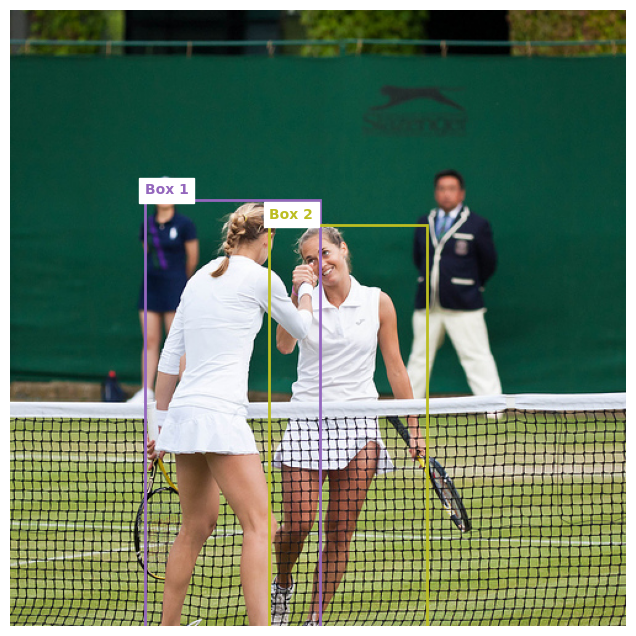

In [70]:
plot_bounding_boxes_xyxy(image_path, eval(total_data["target_words"].iloc[i])[j]["bbox"])

In [78]:
# pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/flicker/downscaled_total_flickr_evidence_head_train_data_30k.csv")

In [72]:
total_data["image_path"] = total_data["image_id"].apply(lambda x: "/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/flicker/flickr30k-images/" + str(int(x)) + ".jpg")

In [73]:
total_data.head(2)

,answer,question,image_id,target_words,downscale_target_words_bb_info,image_path
0,Three people are on a sidewalk.,How many people are on the sidewalk?,1191423753,"[{'word': 'Three', 'bbox': [{'xmin': 351, 'ymi...","[{'word': 'Three', 'bbox': [{'xmin': 258, 'ymi...",/Data2/Arun-UAV/NLP/vision_halu/evidence_head_...
1,"Beautiful brunette woman, draped in purple, bl...",What colors are the scarves draped around the ...,1360456780,"[{'word': 'Beautiful', 'bbox': [{'xmin': 106, ...","[{'word': 'Beautiful', 'bbox': [{'xmin': 24, '...",/Data2/Arun-UAV/NLP/vision_halu/evidence_head_...
